# CS 582 Coding Assignment 1

This notebook contains the code and analysis for analyzing the SciPlex dataset for perturbation prediction.

In [1]:
# Python standard library imports
import os
from random import seed
from collections import Counter

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score

# Pytorch and Pytorch Geometric libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.loader import GraphSAINTRandomWalkSampler

# Libraries for single-cell analysis
import anndata
import scanpy as sc

/vast/palmer/home.mccleary/sr2464/.conda/envs/pyg_torch2.1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tqdm import tqdm

In [3]:
RANDOM_SEED = 1234
seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
# View all columns of Pandas DataFrames:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Project Overview

In this project, we explore perturbation prediction in single-cell RNA sequencing (scRNAseq) data using Graph Neural Networks (GNNs) and explainability frameworks. The goal will be to perform accurate **perturbation prediction**, where we train a deep learning model, specifically a GNN, to predict the drug perturbation which was applied to a given cell based on its gene expression. Furthermore, in order to identify genes which contributed to or are responsible for model predictions, we utilize GNN explainability frameworks in order to explain GNN predictions and identify important features, nodes, and edges in the input graph. Additional discussion for the rationale of using GNNs for modeling single-cell data, as well as methodology are documented throughout this notebook.

Concretely, the goals will be to:
1. Train a Graph Neural Network to do drug perturbation prediction on scRNAseq data
2. Implement a GNN explainability framework to explain model predictions
3. Analyze important genes which factor into GNN predictions for specific drugs

The dataset we will be using will be the SciPlex dataset [1], which is a scRNAseq screening dataset consisting of 188 drug compounds applied to three different cell lines across thousands of samples. The sci-Plex methodology itself which enables the massive perturbational screening involves oligo nuclear hashing, which helps to quantify transcriptional responses to numerous independent perturbations at single-cell resolution. For the scope of this project, we will be using the A549 cancer cell line, which is a cell line of lung alveolus epithelial cells.

Dataset Download Link:
https://cellxgene.cziscience.com/collections/00109df5-7810-4542-8db5-2288c46e0424

References:
1. Srivatsan, Sanjay R., et al. "Massively multiplex chemical transcriptomics at single-cell resolution." Science 367.6473 (2020): 45-51.

# Load Data

There are three cancerous cell lines in the sciPlex dataset: A549 (lung alveolus epithelial cells), K562 (cultured cells), and MCF7 (mammary gland).

We start by loading the annotated data object (anndata object) for the A549 cancer cell line. We see that it has many cell metadata and annotations in the .obs DataFrame, as well as information about the genomic features in the .var attribute.

In [5]:
PATH = "/home/sr2464/palmer_scratch/CS582_Coding_Assignment/SciPlexData/A549_lung_alveolus_epithelial_cell_culture.h5ad"
adata = anndata.read_h5ad(PATH)
adata

AnnData object with n_obs × n_vars = 143015 × 55773
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 

In [6]:
adata.obs.head()

,sample,Size_Factor,n.umi,hash_umis_W,pval_W,qval_W,top_to_second_best_ratio_W,hash_umis_P,pval_P,qval_P,top_to_second_best_ratio_P,rt_well,lig_well,pcr_well,pcr_plate,rt_plate,lig_plate,Combo,well_oligo,plate_oligo,replicate,time_point,drug_dose,catalog_number,vehicle,dose_pattern,dose,pathway_level_1,pathway_level_2,product_name,target,pathway,product_dose,viability,num_genes_expressed,g1s_score,g2m_score,proliferation_index,Cluster,louvain_component,disease_ontology_term_id,donor_id,assay_ontology_term_id,tissue_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,is_primary_data,organism_ontology_term_id,suspension_type,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
A01_E09_RT_BC_100_Lig_BC_245,Chem3_Screen2,2.296651,3094,373,0.0,0.0,52.807724,209,0.000000e+00,0.000000e+00,56.814318,100,245,A01,E09,2,3,plate9_C3plate39,plate9_C3,plate39,rep2,24,S1055_2,S1055,False,2,1000,PKC signaling,PKC activitiy,Enzastaurin (LY317615),PKC,TGF-beta/Smad,Enzastaurin (LY317615)_1000,0.999924,1571,1.155964,2.475312,2.643512,1,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,+pQibXbkV6
A01_E09_RT_BC_100_Lig_BC_306,Chem3_Screen2,0.480141,646,23,0.0,0.0,10.053193,25,1.067310e-191,8.485111e-189,19.800273,100,306,A01,E09,2,4,plate10_D6plate40,plate10_D6,plate40,rep2,24,S1192_4,S1192,False,4,10,DNA damage & DNA repair,Nucleotide analog,Raltitrexed,DNA/RNA Synthesis,DNA Damage,Raltitrexed_10,0.997575,417,0.000000,1.980748,1.980748,2,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,5A~&6zx%%T
A01_E09_RT_BC_101_Lig_BC_109,Chem3_Screen2,0.516561,695,93,0.0,0.0,27.803759,117,0.000000e+00,0.000000e+00,43.313841,101,109,A01,E09,2,2,plate6_G5plate12,plate6_G5,plate12,rep1,24,S0002_3,S0000,True,3,0,Vehicle,Vehicle,Vehicle,Vehicle,Vehicle,Vehicle_0,1.000000,421,0.000000,0.000000,0.000000,2,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,pGI4g(d5me
A01_E09_RT_BC_101_Lig_BC_229,Chem3_Screen2,0.387978,523,75,0.0,0.0,63.947847,101,0.000000e+00,0.000000e+00,1886.909392,101,229,A01,E09,2,3,plate8_C5plate38,plate8_C5,plate38,rep2,24,S1029_4,S1029,False,4,10,Protein folding & Protein degradation,E3 ubiquitin ligase activity,Lenalidomide (CC-5013),TNF-alpha,Apoptosis,Lenalidomide (CC-5013)_10,0.999966,428,1.817254,2.801225,3.073606,7,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,G)G1o2fD<U
A01_E09_RT_BC_101_Lig_BC_280,Chem3_Screen2,0.724671,976,102,0.0,0.0,25.832608,127,0.000000e+00,0.000000e+00,475.679099,101,280,A01,E09,2,3,plate3_G1plate33,plate3_G1,plate33,rep2,24,S1703_2,S1703,False,2,1000,Epigenetic regulation,Histone deacetylation,Divalproex Sodium,HDAC,Ubiquitin,Divalproex Sodium_1000,0.953656,714,1.637016,0.867074,1.874835,10,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,gY;lI#JE~o


In [7]:
Counter(adata.obs["cell_type"])

Counter({'cultured cell': 143015})

In [8]:
drug_perturbations_counter = Counter(adata.obs["product_name"])
print(len(drug_perturbations_counter))  # 189 drug compounds
drug_perturbations_counter

189


Counter({'Enzastaurin (LY317615)': 687,
         'Raltitrexed': 707,
         'Vehicle': 3287,
         'Lenalidomide (CC-5013)': 844,
         'Divalproex Sodium': 546,
         'MLN8054': 429,
         'Sodium Phenylbutyrate': 937,
         'Celecoxib': 802,
         'Linifanib (ABT-869)': 891,
         'Thalidomide': 780,
         'SNS-314': 528,
         '(+)-JQ1': 683,
         'S3I-201': 860,
         'AZD1480': 661,
         'PF-573228': 660,
         'CEP-33779': 894,
         'Resminostat': 750,
         'Tie2 kinase inhibitor': 905,
         'Nintedanib (BIBF 1120)': 947,
         'SRT3025 HCl': 549,
         'Avagacestat (BMS-708163)': 814,
         'Quisinostat (JNJ-26481585) 2HCl': 477,
         'MC1568': 713,
         'Temsirolimus (CCI-779, NSC 683864)': 559,
         'IOX2': 902,
         'Bosutinib (SKI-606)': 899,
         'Regorafenib (BAY 73-4506)': 761,
         'Aurora A Inhibitor I': 632,
         'ENMD-2076': 759,
         'Curcumin': 870,
         'NVP-BSK805 2

The signal of different perturbations in single cells can be weak, and are not very well separable among many different perturbation compounds. We therefore focus on five perturbation compounds for this project, to narrow down the data by specific perturbation compounds and analyze what genes are important for predicting thoe specific compounds

In [9]:
selected_perturbations = ["Abexinostat (PCI-24781)", "Entinostat (MS-275)", "IOX2", "TAK-901"]

In [10]:
adata = adata[adata.obs["product_name"].isin(selected_perturbations)].copy()
adata

AnnData object with n_obs × n_vars = 3063 × 55773
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 't

In [11]:
drug_perturbations_counter = Counter(adata.obs["product_name"])
print(len(drug_perturbations_counter))  # 189 drug compounds
drug_perturbations_counter

4


Counter({'IOX2': 902,
         'Abexinostat (PCI-24781)': 687,
         'Entinostat (MS-275)': 936,
         'TAK-901': 538})

In [12]:
adata.var.head()

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length
feature_id,,,,,
ENSG00000278340,False,MIR6862-2,NCBITaxon:9606,gene,70
ENSG00000205328,False,OR6C65,NCBITaxon:9606,gene,939
ENSG00000237481,False,RP4-803J11.2,NCBITaxon:9606,gene,640
ENSG00000228118,False,MYL6P5,NCBITaxon:9606,gene,459
ENSG00000248245,False,CTB-49A3.2,NCBITaxon:9606,gene,816


In [13]:
# Switch index of .var attribute to gene names, make sure all gene names are capitalized
adata.var["gene_names"] = adata.var["feature_name"].astype(str).copy()
adata.var["gene_names"] = adata.var["gene_names"].apply(lambda x: x.upper())
adata.var["Ensembl_IDs"] = adata.var.index.copy()
adata.var.index = adata.var["gene_names"]

In [14]:
adata.var.head()

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,gene_names,Ensembl_IDs
gene_names,,,,,,,
MIR6862-2,False,MIR6862-2,NCBITaxon:9606,gene,70,MIR6862-2,ENSG00000278340
OR6C65,False,OR6C65,NCBITaxon:9606,gene,939,OR6C65,ENSG00000205328
RP4-803J11.2,False,RP4-803J11.2,NCBITaxon:9606,gene,640,RP4-803J11.2,ENSG00000237481
MYL6P5,False,MYL6P5,NCBITaxon:9606,gene,459,MYL6P5,ENSG00000228118
CTB-49A3.2,False,CTB-49A3.2,NCBITaxon:9606,gene,816,CTB-49A3.2,ENSG00000248245


In [15]:
adata.var.dtypes

feature_is_filtered        bool
feature_name           category
feature_reference      category
feature_biotype        category
feature_length         category
gene_names               object
Ensembl_IDs              object
dtype: object

In [16]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

Looking a bit more closely, we can see that the data has 143015 cells and 55773 genes. The cell x gene matrix, stored in the .X attribute, contains raw counts, which are integers representing how many RNA transcripts were captured for that gene in that particular cell.

In [17]:
adata

AnnData object with n_obs × n_vars = 3063 × 55773
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 't

In [18]:
adata.X.data[:10]  # Raw integer counts of RNA transcripts

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 5.], dtype=float32)

# Data preprocessing and visualization

Since the data we loaded is unprocessed, we will need to perform standard filtering and normalization steps in order to preprocess the scRNAseq data before we can train Machine Learning models on it. We will follow a great preprocessing and data visualization guide from the Scanpy library:

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [19]:
# Basic filtering of cells with too few genes expressed and genes expressed in too few cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [20]:
adata  # We can see that a few cells and a few thousand genes were filtered out

AnnData object with n_obs × n_vars = 3063 × 19033
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 't

In [21]:
# Filtering cells by statistics about mitochondrial gene counts. Follows intuition that healthy cells should not have
# a high proportion of counts coming from mitochondrial genes
#  annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [22]:
adata

AnnData object with n_obs × n_vars = 3063 × 19033
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 't

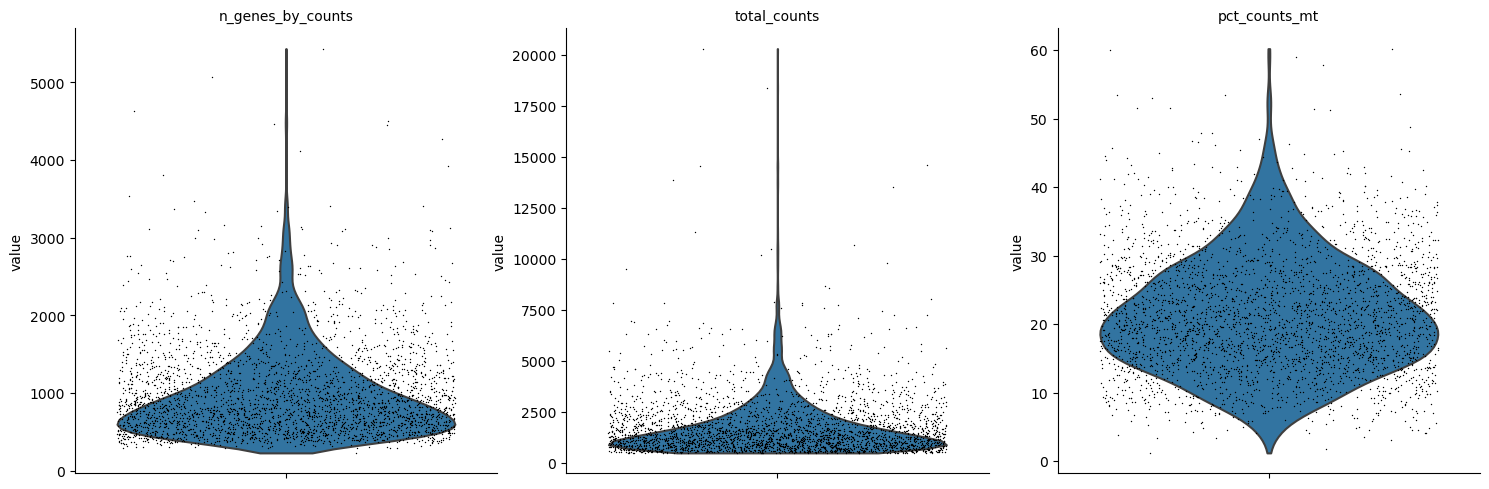

In [23]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True
)

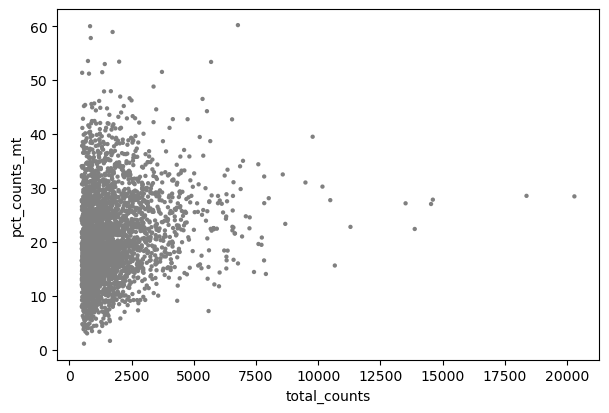

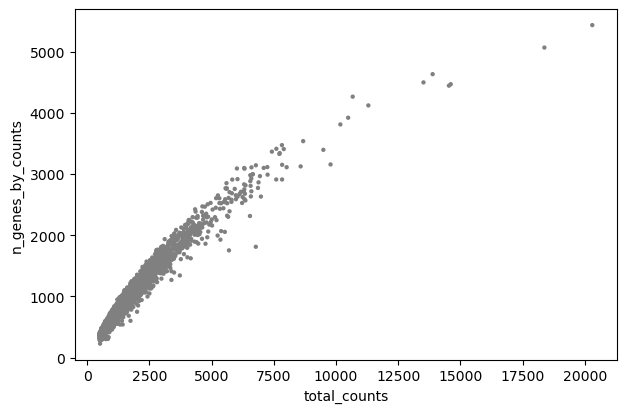

In [24]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

From the plots, we can see that there are outlier cells which have n_genes_by_counts > 4000, and which have over 60 percent of their counts coming from mitochondrial genes, which is too high for normal cells. We therefore filter them out.

In [25]:
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.pct_counts_mt < 50, :].copy()

In [26]:
adata

AnnData object with n_obs × n_vars = 3043 × 19033
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 't

Now we normalize all counts to sum up to 10000 for all cells, so that counts become comparable across cells

In [27]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [28]:
adata.X.data.shape

(2976305,)

A quick peek at the nonzero values in our data tells us that things are heavily exponentially distributed, so we do a log normalization on the entire cell x gene matrix. We do log1p so that zero counts stay as zero after the log transformation.

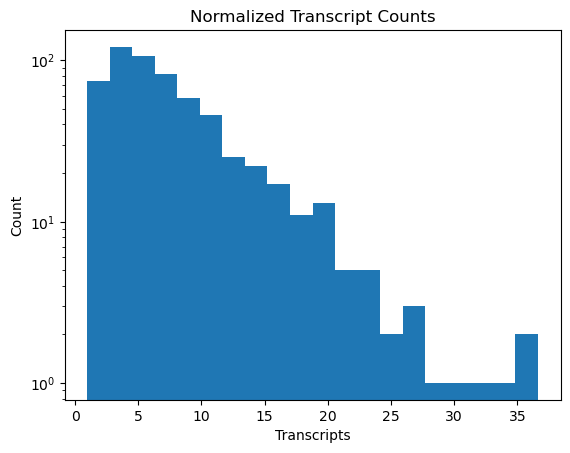

In [29]:
plt.hist(adata.X.data[::5000], bins=20)
plt.title("Normalized Transcript Counts")
plt.xlabel("Transcripts")
plt.ylabel("Count")
plt.yscale("log")
plt.show()
plt.close()

In [30]:
sc.pp.log1p(adata)

Our data is now in a better range after log transformation, however it is still not in a great range for neural networks. We add on an additional step here of min-max normalization to bring the expression into range [0, 1].

We know, however, that there can be outlier values in the expression, as seen in our filtering steps. We want the majority of our data to fall into the [0,1] range with good density, so we can normalize by the 99.9th percentile rather than the 100th percentile, so that outliers do not push our value range to become too small.

In [31]:
print(adata.X.max())
print(adata.X.min())

8.209673
0.0


In [32]:
ninety_ninth = np.percentile(adata.X.data, 99.0)
print("ninety_ninth:", ninety_ninth)
print("max value:", adata.X.data.max())

ninety_ninth: 3.737279176712036
max value: 8.209673


In [33]:
# adata.X is a sparse matrix, and the minimum value in the matrix is 0, so it will be sufficient to divide the .data attribute of the 
#  sparse matrix in order to scale into relative [0, 1] range
adata.X.data /= ninety_ninth
print("max value:", adata.X.data.max())

max value: 2.1966977


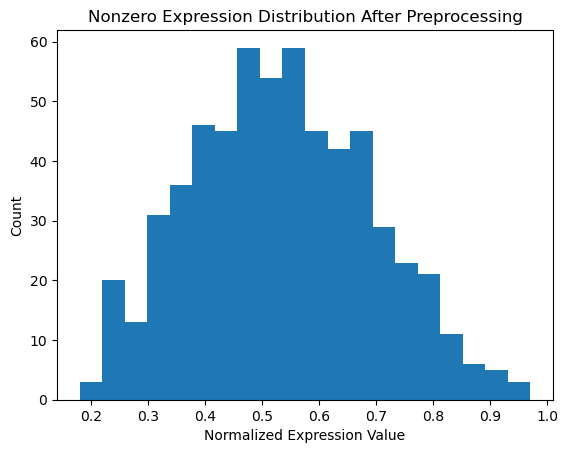

In [34]:
plt.hist(adata.X.data[::5000], bins=20)
plt.title("Nonzero Expression Distribution After Preprocessing")
plt.xlabel("Normalized Expression Value")
plt.ylabel("Count")
plt.show()
plt.close()

We can see that after our preprocessing steps, we have a nice normal distribution of values prmarily in the range [0, 1], but not biased by outliers. This will be good as input for our GNN later on. We will save the preprocessed anndata object in a specific variable for later input into our GNN model. The adata we have currently will continue to be modified for visualization purposes.

In [35]:
preprocessed_adata_cp10k_log1p_minmax = adata.copy()
preprocessed_adata_cp10k_log1p_minmax

AnnData object with n_obs × n_vars = 3043 × 19033
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 't

We now continue with the Scanpy tutorial, which contains a few more useful visualization and calculation steps

In [36]:
# Finding highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

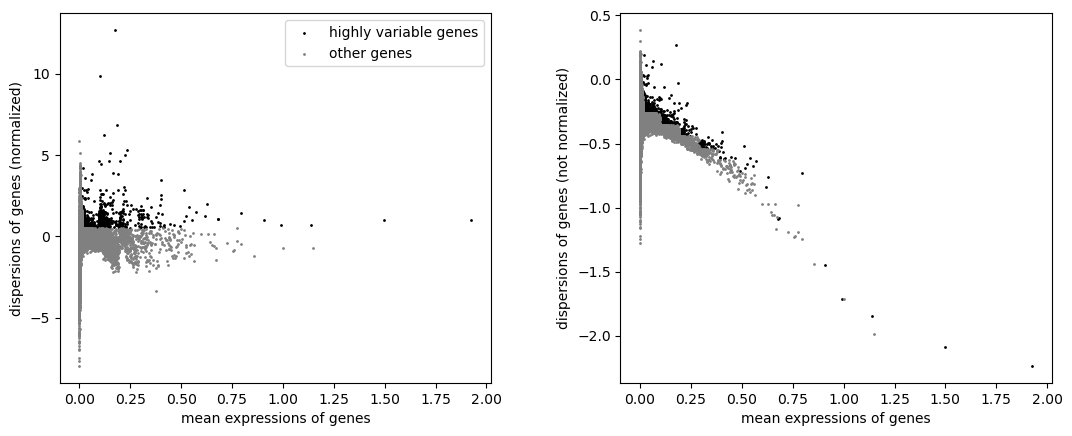

In [37]:
sc.pl.highly_variable_genes(adata)

In [38]:
# For visualization, we will be plotting things only using highly variable genes. Filter to HVGs here:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 3043 × 1389
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 's

In [39]:
# Here we regress out the effects of total_counts and mitochondrial gene percentage expressed, and we scale the
#  data to zero mean and unit variance before computing PCA
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)

In [40]:
# Calculate PCA on data
sc.tl.pca(adata, svd_solver="arpack")
# sc.pl.pca_variance_ratio(adata, log=False)  # To examine variance explained ratio

In [41]:
# Compute a neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

Here we plot a UMAP of the data, colored by drug perturbation compound

In [42]:
sc.tl.umap(adata)

/vast/palmer/home.mccleary/sr2464/.conda/envs/pyg_torch2.1/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


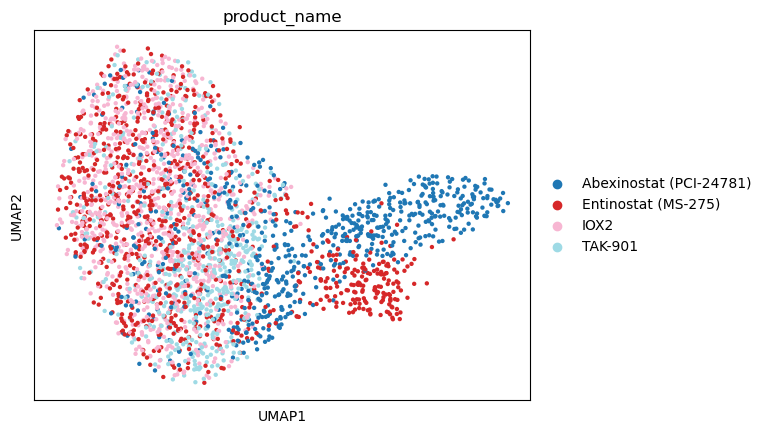

In [43]:
sc.pl.umap(adata, color="product_name", palette='tab20')  # list(matplotlib.colors.CSS4_COLORS.values())

# Model Development

In this section, we define our Graph Neural Network along with dataloaders, training loops, and other training utilities.

Motivation for using Graph Neural Networks:
- GNNs are a Deep Learning architecture which operates over graph-structured data, which in the context of single-cell sequencing data means a graph composed of nodes which represent cells and edges which represent connections between cells. In a spatial transcriptomics dataset, the edges might come from the 2D spatial graph given by the spatial sequencing method, however in regular scRNAseq data we can construct a K-nearest neighbors graph based on expression similarity between cells to get a graph structure.
- In scRNASseq data, cell measurements are sparse and noisy due to the nature of the sequencing technology. The benefit of using GNNs is that in a K-neighbors graph, a given cell will have its signal reinforced by similar cells in the dataset based on the construction of the K-neighbors graph. In a spatial dataset, the graph structure would be modeling real-world spatial structure, which also comes with benefits for modeling the data according to its natural structure.
- In addition to operating over a flexible representation of data, GNNs also have explainability frameworks such as GNNExplainer [1] and PGM-Explainer [2], which aim to produce explanations for trained GNN models over arbitrary input graphs. This is useful for explaining predictions and doing feature attribution on data that has domain-specific node and edge entities, which is what we will be implementing in this assignment.

References:
1. Ying, Zhitao, et al. "Gnnexplainer: Generating explanations for graph neural networks." Advances in neural information processing systems 32 (2019).
2. Vu, Minh, and My T. Thai. "Pgm-explainer: Probabilistic graphical model explanations for graph neural networks." Advances in neural information processing systems 33 (2020): 12225-12235.

### Preparation for training

We now prepare the dataloader and utilities for training our GNN for perturbation prediction. First, we need to construct a N-neighbors graph from our processed adata object, and convert the perturbation compound names into integer labels

In [44]:
preprocessed_adata_cp10k_log1p_minmax

AnnData object with n_obs × n_vars = 3043 × 19033
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 't

In [45]:
sc.tl.pca(preprocessed_adata_cp10k_log1p_minmax, svd_solver="arpack", n_comps=200)
sc.pp.neighbors(preprocessed_adata_cp10k_log1p_minmax, n_neighbors=5, n_pcs=200)

In [46]:
print(preprocessed_adata_cp10k_log1p_minmax.obsp["connectivities"].dtype)
print(preprocessed_adata_cp10k_log1p_minmax.obsp["connectivities"].shape)

float32
(3043, 3043)


In [47]:
total_edge_index, total_edge_attr = dense_to_sparse(torch.from_numpy(preprocessed_adata_cp10k_log1p_minmax.obsp["connectivities"].toarray()))
print(total_edge_index.shape)
print(total_edge_attr.shape)

torch.Size([2, 24006])
torch.Size([24006])


Here, we make a column of integer labels corresponding to the 189 drug perturbations applied to different cells

In [48]:
preprocessed_adata_cp10k_log1p_minmax.obs.head()

,sample,Size_Factor,n.umi,hash_umis_W,pval_W,qval_W,top_to_second_best_ratio_W,hash_umis_P,pval_P,qval_P,top_to_second_best_ratio_P,rt_well,lig_well,pcr_well,pcr_plate,rt_plate,lig_plate,Combo,well_oligo,plate_oligo,replicate,time_point,drug_dose,catalog_number,vehicle,dose_pattern,dose,pathway_level_1,pathway_level_2,product_name,target,pathway,product_dose,viability,num_genes_expressed,g1s_score,g2m_score,proliferation_index,Cluster,louvain_component,disease_ontology_term_id,donor_id,assay_ontology_term_id,tissue_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,is_primary_data,organism_ontology_term_id,suspension_type,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
A01_E09_RT_BC_109_Lig_BC_62,Chem3_Screen2,0.376086,506,113,0.0,0.0,95.701597,64,0.0,0.0,15.586803,109,62,A01,E09,2,1,plate5_B5plate11,plate5_B5,plate11,rep1,24,S2919_1,S2919,False,1,10000,HIF signaling,HIF prolyl-hydroxylation,IOX2,HIF,Angiogenesis,IOX2_10000,1.000000,383,1.297181,2.659898,2.830492,4,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,KVM*A=*%WS,383,383,506.0,71.0,14.031620
A01_E09_RT_BC_126_Lig_BC_323,Chem3_Screen2,0.855484,1151,204,0.0,0.0,67.494855,113,0.0,0.0,24.983196,126,323,A01,E09,2,4,plate5_B5plate11,plate5_B5,plate11,rep1,24,S2919_1,S2919,False,1,10000,HIF signaling,HIF prolyl-hydroxylation,IOX2,HIF,Angiogenesis,IOX2_10000,1.000000,836,0.774234,1.736197,1.923467,7,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,CP@7DDRlm8,834,831,1144.0,127.0,11.101398
A01_E09_RT_BC_14_Lig_BC_269,Chem3_Screen2,1.097784,1477,226,0.0,0.0,76.807363,412,0.0,0.0,240.413669,14,269,A01,E09,1,3,plate4_C8plate10,plate4_C8,plate10,rep1,24,S1090_4,S1090,False,4,10,Epigenetic regulation,Histone deacetylation,Abexinostat (PCI-24781),HDAC,Cytoskeletal Signaling,Abexinostat (PCI-24781)_10,0.999997,786,0.000000,0.000000,0.000000,2,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,NYO|yqV1_<,784,781,1471.0,533.0,36.233856
A01_E09_RT_BC_172_Lig_BC_110,Chem3_Screen2,0.506898,683,83,0.0,0.0,53.649498,181,0.0,0.0,572.480089,172,110,A01,E09,2,2,plate3_C8plate9,plate3_C8,plate9,rep1,24,S1090_2,S1090,False,2,1000,Epigenetic regulation,Histone deacetylation,Abexinostat (PCI-24781),HDAC,Cytoskeletal Signaling,Abexinostat (PCI-24781)_1000,0.995370,469,0.000000,0.000000,0.000000,15,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,nxPY>9w}n;,467,464,672.0,126.0,18.750000
A01_E09_RT_BC_194_Lig_BC_128,Chem3_Screen2,0.735077,990,250,0.0,0.0,112.988058,167,0.0,0.0,81.047458,194,128,A01,E09,3,2,plate9_A9plate15,plate9_A9,plate15,rep1,24,S1053_2,S1053,False,2,1000,Epigenetic regulation,Histone deacetylation,Entinostat (MS-275),HDAC,Epigenetics,Entinostat (MS-275)_1000,0.995887,751,0.000000,2.583516,2.583516,1,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,PYiE`dR`8A,747,746,976.0,79.0,8.094262


In [49]:
unique_drug_perturbations = list(set(preprocessed_adata_cp10k_log1p_minmax.obs["product_name"].tolist()))
unique_drug_perturbations.sort(key=str.lower)
print(len(unique_drug_perturbations))
unique_drug_perturbations[:10]

4


['Abexinostat (PCI-24781)', 'Entinostat (MS-275)', 'IOX2', 'TAK-901']

In [50]:
drug_pert_to_int_label = {}
for drug_pert_name in unique_drug_perturbations:
    drug_pert_to_int_label[drug_pert_name] = len(drug_pert_to_int_label)

In [51]:
drug_pert_to_int_label

{'Abexinostat (PCI-24781)': 0,
 'Entinostat (MS-275)': 1,
 'IOX2': 2,
 'TAK-901': 3}

In [52]:
preprocessed_adata_cp10k_log1p_minmax.obs["drug_perturbation_int_label"] = preprocessed_adata_cp10k_log1p_minmax.obs["product_name"].map(drug_pert_to_int_label)
preprocessed_adata_cp10k_log1p_minmax.obs[["sample", "product_name", "drug_perturbation_int_label"]].head()

,sample,product_name,drug_perturbation_int_label
A01_E09_RT_BC_109_Lig_BC_62,Chem3_Screen2,IOX2,2
A01_E09_RT_BC_126_Lig_BC_323,Chem3_Screen2,IOX2,2
A01_E09_RT_BC_14_Lig_BC_269,Chem3_Screen2,Abexinostat (PCI-24781),0
A01_E09_RT_BC_172_Lig_BC_110,Chem3_Screen2,Abexinostat (PCI-24781),0
A01_E09_RT_BC_194_Lig_BC_128,Chem3_Screen2,Entinostat (MS-275),1


In [53]:
cell_labels = torch.tensor(preprocessed_adata_cp10k_log1p_minmax.obs["drug_perturbation_int_label"].tolist(), dtype=torch.int64)
print(cell_labels.shape)
cell_labels[:10]

torch.Size([3043])


tensor([2, 2, 0, 0, 1, 3, 2, 2, 3, 2])

Create a PyG graph object from the anndata, and split the data into train, val, and test using the RandomNodeSplit() utility function from Pytorch Geometric

In [54]:
gene_expression_matrix = preprocessed_adata_cp10k_log1p_minmax.X.toarray()
gene_expression_matrix.shape

(3043, 19033)

In [55]:
full_data_graph = Data(
    x=torch.from_numpy(gene_expression_matrix),
    edge_index=total_edge_index,
    edge_attr=total_edge_attr,
    y=cell_labels,
    num_nodes=gene_expression_matrix.shape[0]
)
full_data_graph

Data(x=[3043, 19033], edge_index=[2, 24006], edge_attr=[24006], y=[3043], num_nodes=3043)

In [56]:
transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
full_data_graph = transform(full_data_graph)
full_data_graph

Data(x=[3043, 19033], edge_index=[2, 24006], edge_attr=[24006], y=[3043], num_nodes=3043, train_mask=[3043], val_mask=[3043], test_mask=[3043])

In [57]:
print(full_data_graph.train_mask.sum())
print(full_data_graph.val_mask.sum())
print(full_data_graph.test_mask.sum())

tensor(2130)
tensor(304)
tensor(609)


Define GraphSAINT subgraph dataloader, for batched training

In [58]:
loader = GraphSAINTRandomWalkSampler(
    full_data_graph, 
    batch_size=100,  # Number of random walks conducted per subgraph sampled 
    walk_length=2,  # Length of random walk. Using default from PyG GraphSAINT tutorial/GraphSAINT paper
    num_steps=10,  # number of minibatch subgraphs in one epoch
    sample_coverage=100,  # Used for calculating normalization statistics at initialization of GraphSAINT loader
    log=False
)
# Note that the loader will return subgraphs which will contain train, val, and test nodes. Train/val/test computations
#  will be split from each other in the training loop when loss and metrics are calculated

## GNN Model Definition

Here, we define our Graph Neural Network architecture for perturbation prediction. We define a GNN with two layers, which will perform two rounds message-passing across edges in the input graph. We do not want to make the GNN much deeper than two layers since this will lead to ovesmoothing (convergence) of node representations, making them indistinguishable from each other. We want each node embedding ideally to capture local neighborhood information for each cell in order to achieve good classification performance on drug perturbations per cell.

In [59]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_node_features: int, hidden_dim: int, output_dim: int, dropout: float):
        super().__init__()
        self.dropout = dropout
        self.conv1 = SAGEConv(num_node_features, hidden_dim)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(p=dropout)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [60]:
len(drug_pert_to_int_label)

4

In [61]:
full_data_graph

Data(x=[3043, 19033], edge_index=[2, 24006], edge_attr=[24006], y=[3043], num_nodes=3043, train_mask=[3043], val_mask=[3043], test_mask=[3043])

In [62]:
# model = GAT(
#     num_node_features=full_data_graph.x.shape[1],
#     hidden_dim=16,
#     output_dim=len(drug_pert_to_int_label),
#     num_attn_heads=4,
#     dropout=0.0,
#     attn_dropout=0.1
# )
model = GraphSAGE(
    num_node_features=full_data_graph.x.shape[1],
    hidden_dim=16,
    output_dim=len(drug_pert_to_int_label),
    dropout=0.1,
)
print(model)

GraphSAGE(
  (conv1): SAGEConv(19033, 16, aggr=mean)
  (act1): ReLU()
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): SAGEConv(16, 4, aggr=mean)
)


In [63]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
trainable_parameter_count = sum([np.prod(p.size()) for p in model_parameters])
print("Trainable parameters:", trainable_parameter_count)

Trainable parameters: 609204


Define a few training hyperparameters

In [64]:
EPOCHS = 50
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5

In [65]:
# criterion = nn.CrossEntropyLoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [67]:
model.to(device)

GraphSAGE(
  (conv1): SAGEConv(19033, 16, aggr=mean)
  (act1): ReLU()
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): SAGEConv(16, 4, aggr=mean)
)

Training loop

In [68]:
def evaluation_loop(model, loader, split="val"):
    """
    This function runs the model on the provided loader, and calculated loss and accuracy
    on either the validation or test set using the subgraph val/test masks.
    """
    assert split in ["val", "test"], "Specify either 'val' or 'test' for split in evaluation loop."
    total_loss = 0.
    total_acc = 0.
    
    with torch.no_grad():
        model.eval()
        for subgraph in loader:
            optimizer.zero_grad()
            subgraph = subgraph.to(device)
            if split == "val":
                node_mask = subgraph.val_mask
            else:
                node_mask = subgraph.test_mask

            # Forward pass through model
            pred_logits = model(subgraph.x, subgraph.edge_index)
            loss = F.nll_loss(pred_logits, subgraph.y, reduction='none')
            loss = (loss * subgraph.node_norm)[node_mask].mean()
            total_loss += loss.item()

            # Calculate metrics
            preds = pred_logits[node_mask]
            preds = preds.argmax(dim=1).cpu().numpy()
            gts = subgraph.y[node_mask].detach().cpu().numpy()
            accuracy = accuracy_score(y_true=gts, y_pred=preds)
            total_acc += accuracy

    avg_loss = total_loss / len(loader)
    avg_acc = total_acc / len(loader)
    return avg_loss, avg_acc

In [69]:
best_val_loss = 1e9
train_acc_list = []
val_acc_list = []
print("Starting training loop:")
for epoch in range(EPOCHS):
    #--- Training Loop ---#
    total_train_loss = 0.
    total_train_acc = 0.
    for subgraph in loader:
        model.train()
        optimizer.zero_grad()
        subgraph = subgraph.to(device)

        # Forward pass through model
        pred_logits = model(subgraph.x, subgraph.edge_index)
        train_loss = F.nll_loss(pred_logits, subgraph.y, reduction='none')
        train_loss = (train_loss * subgraph.node_norm)[subgraph.train_mask].mean()
        total_train_loss += train_loss.item()

        # Calculate metrics
        train_preds = pred_logits[subgraph.train_mask]
        train_preds = train_preds.argmax(dim=1).cpu().numpy()
        train_gts = subgraph.y[subgraph.train_mask].detach().cpu().numpy()
        train_acc = accuracy_score(y_true=train_gts, y_pred=train_preds)
        total_train_acc += train_acc

        train_loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(loader)
    avg_train_acc = total_train_acc / len(loader)
    avg_val_loss, avg_val_acc =  evaluation_loop(model, loader, split="val")

    improved_str = ""
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        improved_str = "(improved val loss)"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict()
        }, "/home/sr2464/Desktop/Perturbation_Prediction_CS582/model_checkpoints/best_model_checkpoint.pth")

    # Print epoch summary
    print(f"Epoch {epoch:03d} | Train Loss: {avg_train_loss: .6f}, Train Acc: {avg_train_acc:.5f} | Valid Loss: {avg_val_loss: .6f}, Valid Acc: {avg_val_acc:.5f} {improved_str}")
    train_acc_list.append(avg_train_acc)
    val_acc_list.append(avg_val_acc)

Starting training loop:
Epoch 000 | Train Loss:  0.005095, Train Acc: 0.37117 | Valid Loss:  0.005243, Valid Acc: 0.36027 (improved val loss)
Epoch 001 | Train Loss:  0.004363, Train Acc: 0.49319 | Valid Loss:  0.004723, Valid Acc: 0.41025 (improved val loss)
Epoch 002 | Train Loss:  0.004097, Train Acc: 0.53355 | Valid Loss:  0.004854, Valid Acc: 0.40408 
Epoch 003 | Train Loss:  0.003746, Train Acc: 0.58981 | Valid Loss:  0.004433, Valid Acc: 0.50691 (improved val loss)
Epoch 004 | Train Loss:  0.003466, Train Acc: 0.61245 | Valid Loss:  0.004073, Valid Acc: 0.47408 (improved val loss)
Epoch 005 | Train Loss:  0.003116, Train Acc: 0.68750 | Valid Loss:  0.004444, Valid Acc: 0.48822 
Epoch 006 | Train Loss:  0.002988, Train Acc: 0.70878 | Valid Loss:  0.004306, Valid Acc: 0.44232 
Epoch 007 | Train Loss:  0.002697, Train Acc: 0.75028 | Valid Loss:  0.004072, Valid Acc: 0.48965 (improved val loss)
Epoch 008 | Train Loss:  0.002598, Train Acc: 0.77187 | Valid Loss:  0.003877, Valid Acc:

We can see that there is a generalization gap between train and validation data, meaning the model performs better on the training set than the validation set. The validation performance does keep improving however, and since validation loss is not going up, we know that this is not an overfit model (i.e. the model does not just memorize training data; it learns rules that improve performance on the validation set as well).

In [70]:
Counter(adata.obs["product_name"])

Counter({'IOX2': 894,
         'Abexinostat (PCI-24781)': 683,
         'Entinostat (MS-275)': 932,
         'TAK-901': 534})

In [71]:
932 / (932 + 894 + 683 + 534)

0.30627670062438384

A majority voting classifier would get 30% classification accuracy on this data, so we know that our trained GNN is much better than random or majority vote. We therefore move on to analyzing what genes drive prediction through GNN explainability frameworks using Pytorch Geometric.

In [72]:
torch.save({
    'model_state_dict': model.state_dict()
}, "/home/sr2464/Desktop/Perturbation_Prediction_CS582/model_checkpoints/final_model_checkpoint.pth")

Now, let's evaluate our model on our test set to get generalization performance on held-out cells

In [73]:
avg_test_loss, avg_test_acc =  evaluation_loop(model, loader, split="test")
print(f"Test Loss: {avg_test_loss:.5f}, Accuracy: {avg_test_acc:.5f}")

Test Loss: 0.00350, Accuracy: 0.62812


# Explaining GNN Predictions

In this section, we implement the GNNExplainer [1] method for explaining GNN model predictions using the Pytorch geometric framework. GNNExplainer will give us subgraph explanations for a given cell classification, including important neighboring nodes and node features (genes) which contributed to the perturbation prediction for that given cell.

In [74]:
from torch_geometric.explain import Explainer
from torch_geometric.explain.algorithm import GNNExplainer

First, we define our PyG GNN explainer instance using the GNNExplainer algorithm

In [75]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

Let's see how explaining the prediction on one cell (node) works:

In [76]:
subgraph = next(iter(loader))
subgraph.to(device)
subgraph

Data(num_nodes=252, edge_index=[2, 1208], x=[252, 19033], edge_attr=[1208], y=[252], train_mask=[252], val_mask=[252], test_mask=[252], node_norm=[252], edge_norm=[1208])

In [77]:
subgraph.test_mask.sum()  # explain predictions on one of the test nodes

tensor(52, device='cuda:0')

In [78]:
test_node_indices = np.where(subgraph.test_mask.cpu())[0]
test_node_indices

array([  5,  12,  25,  33,  40,  44,  45,  48,  51,  57,  60,  63,  70,
        84,  87,  91,  94, 101, 102, 106, 112, 116, 117, 119, 120, 127,
       133, 134, 143, 148, 150, 163, 170, 171, 178, 180, 185, 188, 194,
       197, 198, 204, 205, 206, 209, 214, 225, 226, 228, 231, 241, 247])

In [79]:
Counter(subgraph.y[subgraph.test_mask].tolist())

Counter({0: 19, 1: 9, 2: 15, 3: 9})

In [80]:
drug_pert_to_int_label

{'Abexinostat (PCI-24781)': 0,
 'Entinostat (MS-275)': 1,
 'IOX2': 2,
 'TAK-901': 3}

In [81]:
node_index = test_node_indices[0]  # explain first test node
explanation = explainer(subgraph.x, subgraph.edge_index, index=node_index)
explanation

Explanation(node_mask=[252, 19033], edge_mask=[1208], prediction=[252, 4], target=[252], index=5, x=[252, 19033], edge_index=[2, 1208])

In [82]:
print(explanation.available_explanations)
print(explanation["node_mask"].shape)

['edge_mask', 'node_mask']
torch.Size([252, 19033])


In [83]:
np.count_nonzero(explanation["node_mask"].cpu().numpy()) / explanation["node_mask"].cpu().numpy().size

0.023390660665394022

The node_mask returned by the explainer algorithm is a cell x gene matrix of importance scores for the input subgraph which we did explanation on. We can see that there are very few nonzero values in this explanation node mask - this is because GNNExplainer outputs a compact subgraph explanation of the input graph, where only a select few neighboring nodes of the node whose drug prediction we explained will have scores above 0 in their vectors.

The node mask serves two purposes: it tells us which neighboring nodes contributed to prediction of this node, and it also tells us which gene features in each node contributed to the prediction (since the mask spans across node features as well.

We can get an overall feature importance matrix by simply summing the cell x gene explanation mask across all nodes/cells, giving us a feature importance vector of shape (num_gene_features):

In [84]:
# We can get importance scores for genes
feat_imp_vector = explanation["node_mask"].cpu().numpy().sum(axis=0)
feat_imp_vector.shape

(19033,)

In [85]:
topk = 10
top10_gene_feat_indices = np.argpartition(feat_imp_vector, -topk)[-topk:]
top10_gene_feat_indices = np.sort(top10_gene_feat_indices)  # sort to make indexing genes more intuitive
top10_gene_feat_indices

array([ 2004,  6195,  6354, 10018, 10302, 10595, 10899, 15499, 16504,
       17917])

In [86]:
print("Top 20 gene features:")
print(preprocessed_adata_cp10k_log1p_minmax.var_names[top10_gene_feat_indices].tolist())

Top 20 gene features:
['MT-RNR2', 'PDE4D', 'MT-ND5', 'ALDH1A1', 'GAPDH', 'MT-CO1', 'MT-ND4', 'MT-CYB', 'MT-RNR1', 'MT-CO3']


In [87]:
feat_imp_vector[top10_gene_feat_indices]

array([19.835857, 17.011847, 16.821363, 16.716179, 16.189661, 16.824669,
       16.944534, 15.440286, 17.50513 , 16.6452  ], dtype=float32)

Indeed, if we check with the PyG explainability feature visualization, we see that we are getting the top 10 gene features

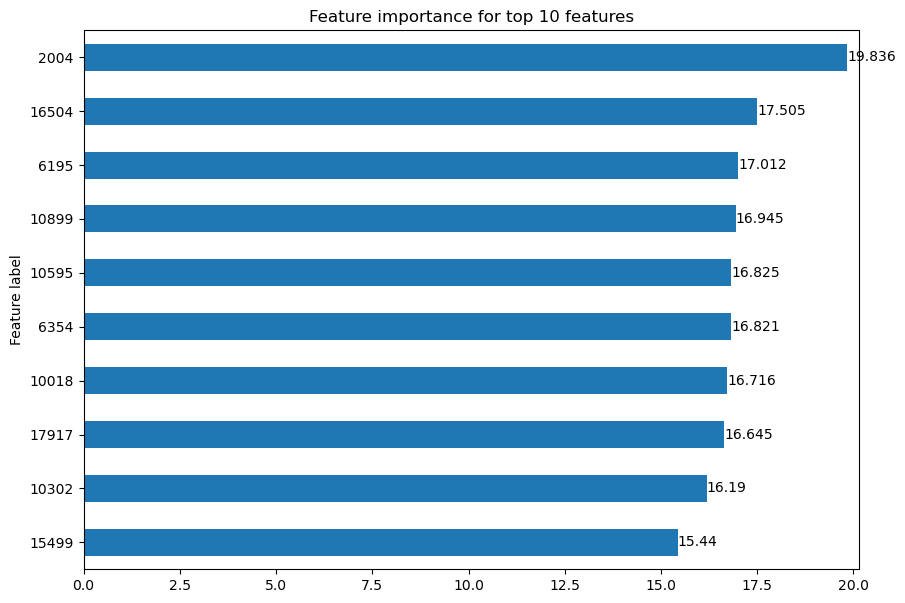

In [88]:
explanation.visualize_feature_importance(None, top_k=10)

Let's now run our explanation over all nodes in our test set:

In [103]:
print(full_data_graph)
print(full_data_graph.test_mask.sum())

Data(x=[3043, 19033], edge_index=[2, 24006], edge_attr=[24006], y=[3043], num_nodes=3043, train_mask=[3043], val_mask=[3043], test_mask=[3043])
tensor(609)


In [108]:
test_node_indices = np.where(full_data_graph.test_mask.cpu())[0]
test_node_indices.shape

(609,)

In [91]:
# Relatively good label proportion among the four drug compounds in the test node set
Counter(full_data_graph.y[full_data_graph.test_mask].tolist())

In [93]:
# full_data_graph.x.shape
full_data_graph.edge_index.shape

In [94]:
# subgraph.x.shape
subgraph.edge_index.shape

In [111]:
test_node_indices.shape

(609,)

Run over 200 test set nodes

In [113]:
test_node_explanations_feat_imp_vector_list = []

for node_index in tqdm(test_node_indices.tolist()[::3]):  # Every 4th test cell, up to index 400 in test nodes
    node_explanation = explainer(full_data_graph.x.to(device), full_data_graph.edge_index.to(device), index=node_index)
    feat_imp_vector = node_explanation["node_mask"].cpu().numpy().sum(axis=0)
    test_node_explanations_feat_imp_vector_list.append(feat_imp_vector)

100%|██████████| 203/203 [27:56<00:00,  8.26s/it]


In [114]:
import pickle

In [115]:
with open('/home/sr2464/Desktop/Perturbation_Prediction_CS582/model_checkpoints/test_node_explanations_feat_imp_vector_list.pkl', 'wb') as f:
    pickle.dump(test_node_explanations_feat_imp_vector_list, f)

Now, we construct Pandas DataFrames containing the top 20 gene features found for each perturbation

In [116]:
drug_pert_to_int_label

{'Abexinostat (PCI-24781)': 0,
 'Entinostat (MS-275)': 1,
 'IOX2': 2,
 'TAK-901': 3}

In [117]:
int_label_to_drug_pert = {v: k for k, v in drug_pert_to_int_label.items()}
int_label_to_drug_pert

{0: 'Abexinostat (PCI-24781)',
 1: 'Entinostat (MS-275)',
 2: 'IOX2',
 3: 'TAK-901'}

In [118]:
topk = 20
# Define lists that will eventually become columns in Pandas DataFrame
gene_names = []
importance_scores = []
explained_node_labels = []

for list_idx, node_index in enumerate(test_node_indices.tolist()[::3]):
    node_label_int = full_data_graph.y[node_index].item()
    node_label_str = int_label_to_drug_pert[node_label_int]

    # Get top 20 gene features and their importance scores
    feat_imp_vector = test_node_explanations_feat_imp_vector_list[list_idx]
    top_gene_feat_indices = np.argpartition(feat_imp_vector, -topk)[-topk:]
    top_gene_feat_indices = np.sort(top_gene_feat_indices)  # sort to make indexing genes more intuitive
    top_gene_feat_names = preprocessed_adata_cp10k_log1p_minmax.var_names[top_gene_feat_indices].tolist()
    top_gene_feat_scores = feat_imp_vector[top_gene_feat_indices]

    for gene_feat_name, gene_feat_score in zip(top_gene_feat_names, top_gene_feat_scores):
        gene_names.append(gene_feat_name)
        importance_scores.append(gene_feat_score)
        explained_node_labels.append(node_label_str)

In [134]:
test_node_indices.shape[0] * 20

12180

In [119]:
feat_importance_total_df = pd.DataFrame({
    "Explained_Node_Label": explained_node_labels,
    "Selected Gene Feature": gene_names,
    "Importance Score": importance_scores,
})
feat_importance_total_df.shape

(4060, 3)

In [122]:
feat_importance_total_df.head()

,Explained_Node_Label,Selected Gene Feature,Importance Score
0,Entinostat (MS-275),MT-ND2,165.975510
1,Entinostat (MS-275),MT-ATP8,156.419357
2,Entinostat (MS-275),MT-RNR2,196.222443
3,Entinostat (MS-275),NEAT1,159.248871
4,Entinostat (MS-275),KRT8,163.568192


In [135]:
Counter(full_data_graph.y[test_node_indices[::3]].tolist())

Counter({1: 54, 0: 51, 2: 61, 3: 37})

In [137]:
print(int_label_to_drug_pert[1], ":", 54 * 20)
print(int_label_to_drug_pert[0], ":", 51 * 20)
print(int_label_to_drug_pert[2], ":", 61 * 20)
print(int_label_to_drug_pert[3], ":", 37 * 20)

Entinostat (MS-275) : 1080
Abexinostat (PCI-24781) : 1020
IOX2 : 1220
TAK-901 : 740


In [123]:
abexinostat_df = feat_importance_total_df[feat_importance_total_df["Explained_Node_Label"] == "Abexinostat (PCI-24781)"]
print(abexinostat_df.shape)
abexinostat_df.head()

(1020, 3)


,Explained_Node_Label,Selected Gene Feature,Importance Score
40,Abexinostat (PCI-24781),COL26A1,14.735290
41,Abexinostat (PCI-24781),MT-ND2,14.522247
42,Abexinostat (PCI-24781),MT-ATP8,14.931225
43,Abexinostat (PCI-24781),MT-RNR2,14.944095
44,Abexinostat (PCI-24781),CLU,14.402442


In [124]:
entinostat_df = feat_importance_total_df[feat_importance_total_df["Explained_Node_Label"] == "Entinostat (MS-275)"]
print(entinostat_df.shape)
entinostat_df.head()

(1080, 3)


,Explained_Node_Label,Selected Gene Feature,Importance Score
0,Entinostat (MS-275),MT-ND2,165.975510
1,Entinostat (MS-275),MT-ATP8,156.419357
2,Entinostat (MS-275),MT-RNR2,196.222443
3,Entinostat (MS-275),NEAT1,159.248871
4,Entinostat (MS-275),KRT8,163.568192


In [125]:
iox2_df = feat_importance_total_df[feat_importance_total_df["Explained_Node_Label"] == "IOX2"]
print(iox2_df.shape)
iox2_df.head()

(1220, 3)


,Explained_Node_Label,Selected Gene Feature,Importance Score
80,IOX2,MT-ND2,130.626373
81,IOX2,MT-ATP8,123.490746
82,IOX2,AKR1B10,128.338898
83,IOX2,MT-RNR2,158.944748
84,IOX2,KRT8,131.320068


In [126]:
tak_901_df = feat_importance_total_df[feat_importance_total_df["Explained_Node_Label"] == "TAK-901"]
print(tak_901_df.shape)
tak_901_df.head()

(740, 3)


,Explained_Node_Label,Selected Gene Feature,Importance Score
200,TAK-901,MYO1E,117.792580
201,TAK-901,MT-ND2,120.900475
202,TAK-901,MT-ATP8,116.586449
203,TAK-901,MT-RNR2,178.189987
204,TAK-901,KRT8,135.070801


# Gene Feature Attritbuion Visualization

Now, let's make a visualization of the feature importance for each of the four perturbation compounds in our dataset based on explaining our trained GNN model:

In [138]:
import seaborn as sns

In [139]:
drug_pert_to_int_label

{'Abexinostat (PCI-24781)': 0,
 'Entinostat (MS-275)': 1,
 'IOX2': 2,
 'TAK-901': 3}

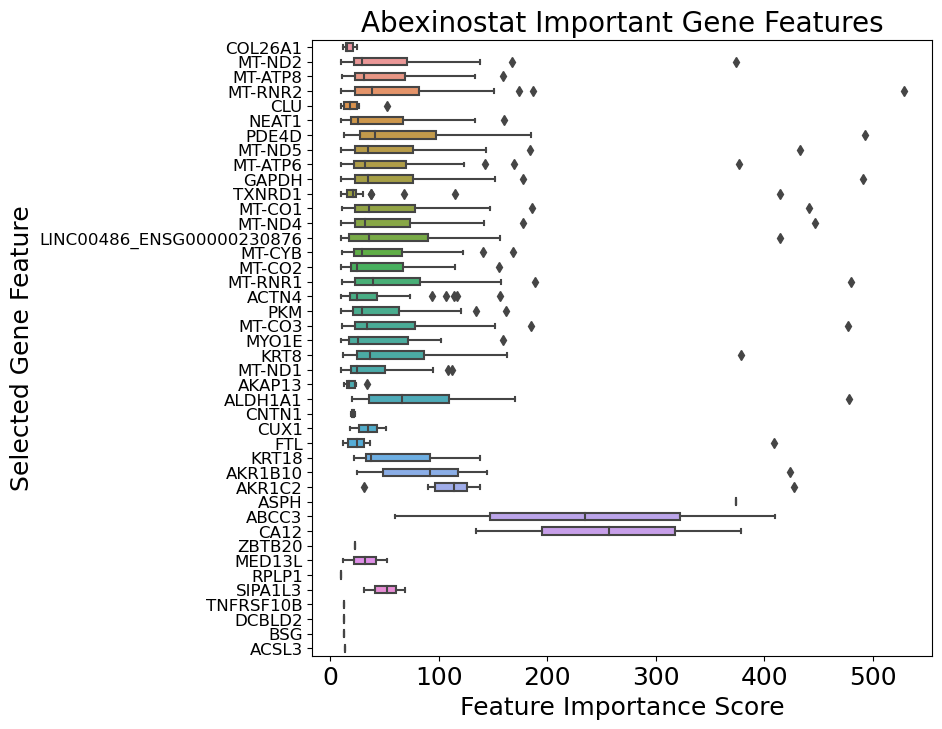

In [149]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=abexinostat_df, x="Importance Score", y="Selected Gene Feature", width=.5)
plt.title("Abexinostat Important Gene Features", fontsize=20)
plt.xlabel("Feature Importance Score", fontsize=18)
plt.ylabel("Selected Gene Feature", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
plt.savefig("/home/sr2464/Desktop/Perturbation_Prediction_CS582/plots/abexinostat_feat_attribution.png", 
            facecolor="white", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

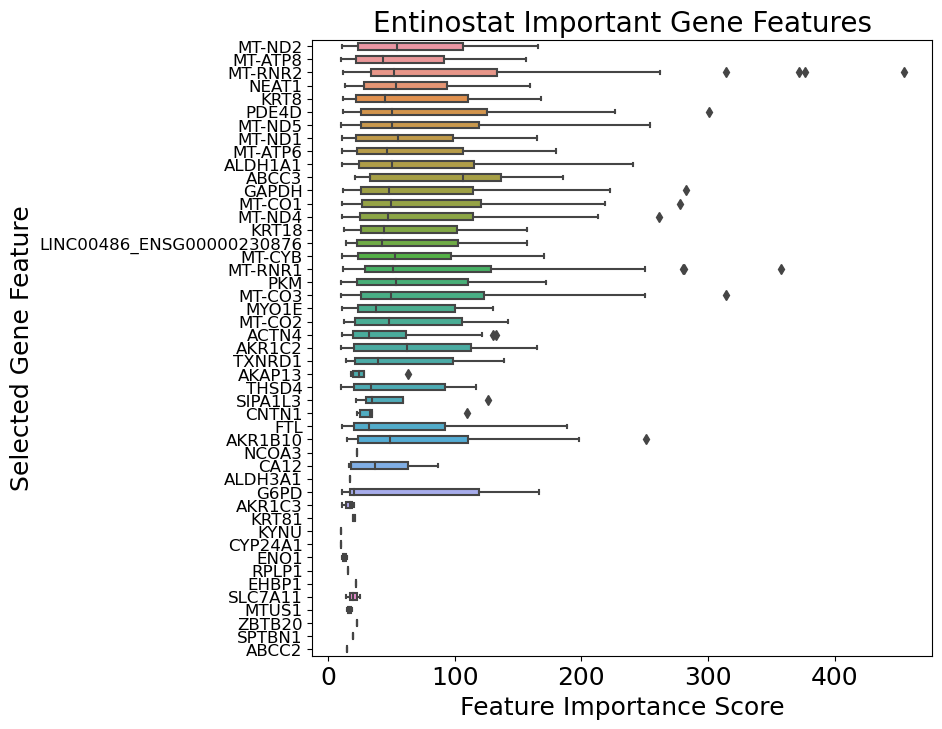

In [150]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=entinostat_df, x="Importance Score", y="Selected Gene Feature", width=.5)
plt.title("Entinostat Important Gene Features", fontsize=20)
plt.xlabel("Feature Importance Score", fontsize=18)
plt.ylabel("Selected Gene Feature", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
plt.savefig("/home/sr2464/Desktop/Perturbation_Prediction_CS582/plots/entinostat_feat_attribution.png", 
            facecolor="white", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

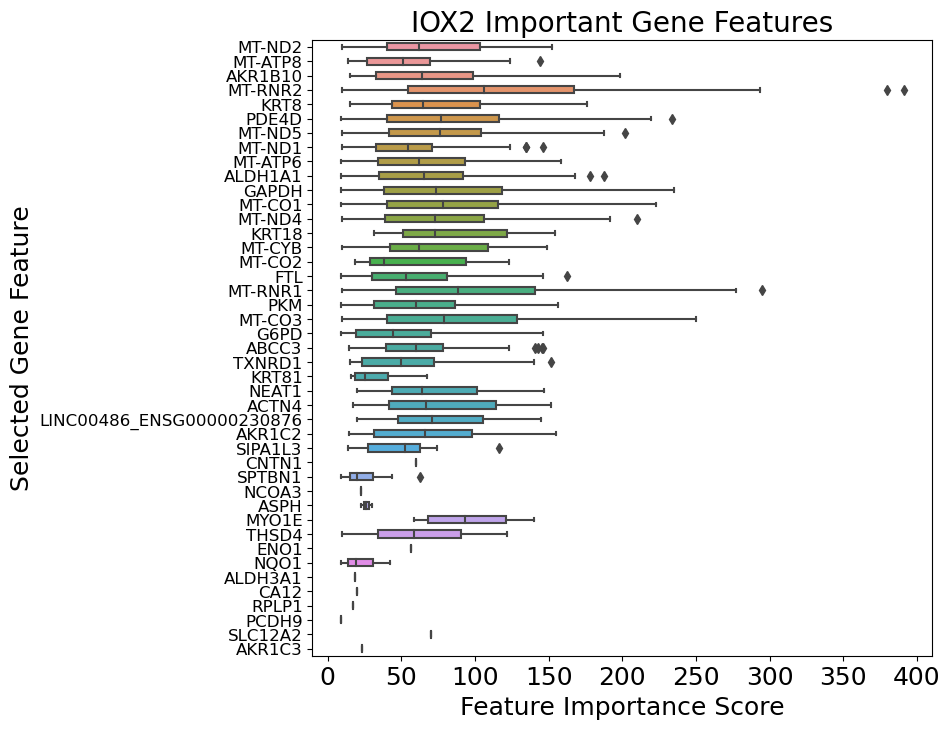

In [151]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=iox2_df, x="Importance Score", y="Selected Gene Feature", width=.5)
plt.title("IOX2 Important Gene Features", fontsize=20)
plt.xlabel("Feature Importance Score", fontsize=18)
plt.ylabel("Selected Gene Feature", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
plt.savefig("/home/sr2464/Desktop/Perturbation_Prediction_CS582/plots/iox2_feat_attribution.png", 
            facecolor="white", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

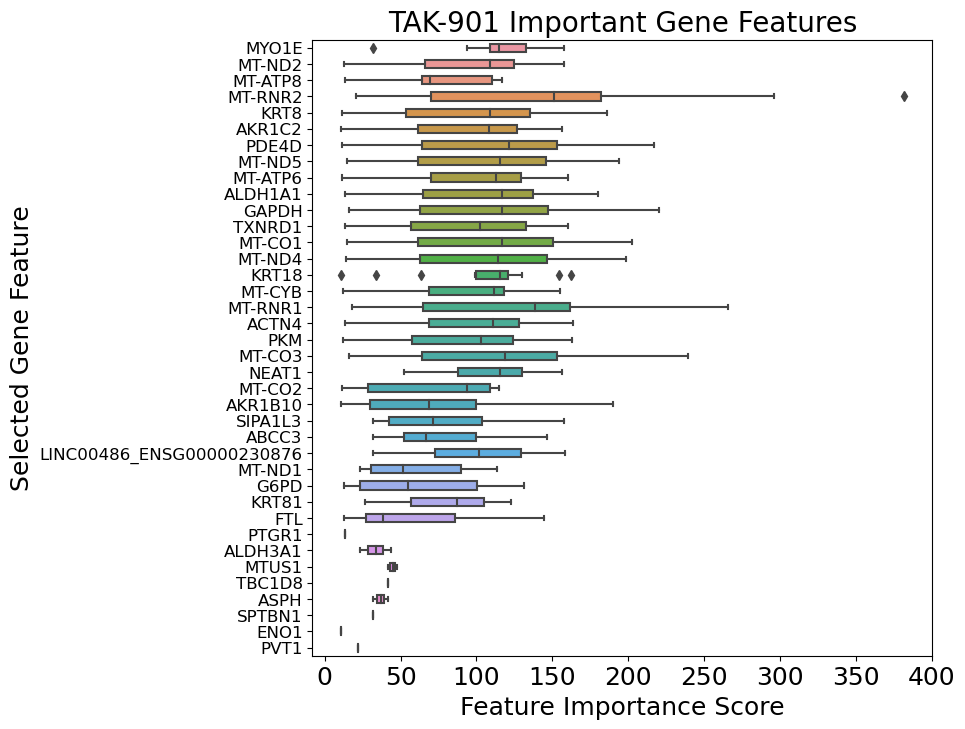

In [152]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=tak_901_df, x="Importance Score", y="Selected Gene Feature", width=.5)
plt.title("TAK-901 Important Gene Features", fontsize=20)
plt.xlabel("Feature Importance Score", fontsize=18)
plt.ylabel("Selected Gene Feature", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
plt.savefig("/home/sr2464/Desktop/Perturbation_Prediction_CS582/plots/tak_901_feat_attribution.png", 
            facecolor="white", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

# Results and Discussion

Overall, we can say that:
- The performance of our GNN model in predicting the four selected perturbations (Abexinostat (PCI-24781), Entinostat (MS-275), IOX2, TAK-901) in the A549 cancer cell line was aroun 62% accuracy, which is much higher than a random or majority classifier (30.6%) would achieve. We can say that our model has some predictive capability of these four drug perturbations.
- While the generalization drug perturbation classification accuracy (62%) was not very high, we can infer that with more training data, the model would perform better, given that the samples were limited to a few thousand cells which had these four perturbations applied to them.
- For the feature attribution, we successfully implemented the GNNExplainer framework for producing explanations of our trained model on the test set cells of the A549 cell line. We were able to obtain the top gene features and their associated scores, and produces visualizations of gene importance importance for each of the four perturbation compounds in our dataset.
- Future work can include scaling this pipeline up to more data (more cell lines), and including more perturbation compounds in the model. For including more drug perturbation compounds, more data samples would likely be required, as well as some model innovation since the signal differentiating the expression of cells with different perturbations is weak. Incorporating prior information about drug perturbations might also be an interesting avenue for further research.